In [1]:
try:
    import davos
except:
    %pip install davos
davos.config.suppress_stdout = True

In [61]:
from bs4 smuggle BeautifulSoup                              # pip: beautifulsoup4==4.12.2
smuggle requests                                            # pip: requests==2.28.2
from tqdm smuggle tqdm                                      # pip: tqdm==4.65.0
smuggle textract                                            # pip: textract==1.6.4
smuggle Levenshtein                                         # pip: levenshtein
smuggle fuzzywuzzy                                          # pip: fuzzywuzzy==0.18.0
smuggle unidecode                                           # pip: Unidecode==1.3.6
smuggle pandas as pd                                        # pip: pandas==2.0.1
smuggle numpy as np                                         # pip: numpy==1.25.2
smuggle seaborn as sns                                      # pip: seaborn==0.12.2
from matplotlib smuggle pyplot as plt                       # pip: matplotlib==3.7.1
from IPython.display import Markdown
smuggle llama_cpp                                           # pip: llama-cpp-python==0.1.83
from langchain.llms smuggle LlamaCpp                        # pip: langchain==0.0.274
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from huggingface_hub smuggle hf_hub_download

from nltk.tokenize smuggle word_tokenize, sent_tokenize     # pip: nltk==3.8.1
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')

smuggle contractions                                       # pip: contractions==0.1.73

smuggle re
smuggle os
smuggle urllib
smuggle json
smuggle string
smuggle warnings
smuggle pickle
from glob smuggle glob as lsdir
from collections import defaultdict

from pathlib smuggle Path

from helpers smuggle format_filename, get_soup, get_pdf_text, get_doc_text, get_dialogue

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jmanning/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Template matching approach

In [107]:
def load_keywords(filename):
    with open(filename, 'r') as f:
        return set(line.strip() for line in f)


def handle_contractions(sentence):
    return contractions.fix(sentence)


def sentence_tense(x):
  # source: https://stackoverflow.com/questions/30016904/determining-tense-of-a-sentence-python
  def tense_detect(tagged_sentence):        
    verb_tags = ['MD','MDF',
                'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
                'DO','DOD','DOZ',
                'HV','HVG','HVN','HVD','HVZ',
                'VB','VBG','VBN','VBD','VBZ',
                'SH',
                'TO',                
                'JJ']
    
    verb_phrase = []
    for item in tagged_sentence:
        if item[1] in verb_tags:
            verb_phrase.append(item)

    grammar = r'''
            future perfect continuous passive:     {<MDF><HV><BEN><BEG><VBN|VBD>+}
            conditional perfect continuous passive:{<MD><HV><BEN><BEG><VBN|VBD>+}
            future continuous passive:             {<MDF><BE><BEG><VBN|VBD>+}   
            conditional continuous passive:        {<MD><BE><BEG><VBN|VBD>+}    
            future perfect continuous:             {<MDF><HV><BEN><VBG|HVG|BEG>+}   
            conditional perfect continuous:        {<MD><HV><BEN><VBG|HVG|BEG>+}
            past perfect continuous passive:       {<HVD><BEN><BEG><VBN|VBD>+}
            present perfect continuous passive:    {<HV|HVZ><BEN><BEG><VBN|VBD>+}
            future perfect passive:                {<MDF><HV><BEN><VBN|VBD>+}   
            conditional perfect passive:           {<MD><HV><BEN><VBN|VBD>+}    
            future continuous:                     {<MDF><BE><VBG|HVG|BEG>+ }   
            conditional continuous:                {<MD><BE><VBG|HVG|BEG>+  }   
            future indefinite passive:             {<MDF><BE><VBN|VBD>+ }
            conditional indefinite passive:        {<MD><BE><VBN|VBD>+  }
            future perfect:                        {<MDF><HV><HVN|BEN|VBN|VBD>+ }   
            conditional perfect:                   {<MD><HV><HVN|BEN|VBN|VBD>+  }   
            past continuous passive:               {<BED|BEDZ><BEG><VBN|VBD>+}  
            past perfect continuous:               {<HVD><BEN><HVG|BEG|VBG>+}   
            past perfect passive:                  {<HVD><BEN><VBN|VBD>+}
            present continuous passive:            {<BEM|BER|BEZ><BEG><VBN|VBD>+}   
            present perfect continuous:            {<HV|HVZ><BEN><VBG|BEG|HVG>+}    
            present perfect passive:               {<HV|HVZ><BEN><VBN|VBD>+}
            future indefinite:                     {<MDF><BE|DO|VB|HV>+ }       
            conditional indefinite:                {<MD><BE|DO|VB|HV>+  }   
            past continuous:                       {<BED|BEDZ><VBG|HVG|BEG>+}           
            past perfect:                          {<HVD><BEN|VBN|HVD|HVN>+}
            past indefinite passive:               {<BED|BEDZ><VBN|VBD>+}   
            present indefinite passive:            {<BEM|BER|BEZ><VBN|VBD>+}            
            present continuous:                    {<BEM|BER|BEZ><BEG|VBG|HVG>+}            
            present perfect:                       {<HV|HVZ><BEN|HVD|VBN|VBD>+  }       
            past indefinite:                       {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}        
            infinitive:                            {<TO><BE|HV|VB>+}
            present indefinite:                    {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}    
            '''

    if len(verb_phrase) > 0:
      cp = nltk.RegexpParser(grammar)
      result = cp.parse(verb_phrase)
    else:
      result = []
    
    tenses_set = set()
    for node in result:
      if type(node) is nltk.tree.Tree:
        tenses_set.add(node.label())
    
    return tenses_set
    
  text = word_tokenize(x)
  tagged = pos_tag(text)
  return tense_detect(tagged)


def analyze_sentence(sentence, past_keywords, future_keywords):
    past_count = 0
    future_count = 0

    sentence = handle_contractions(sentence)
    
    # Check for past and future keywords
    past_kw_found = any(keyword in sentence for keyword in past_keywords)
    future_kw_found = any(keyword in sentence for keyword in future_keywords)

    # Count up to one past and/or future reference based on keywords
    past_count += int(past_kw_found)
    future_count += int(future_kw_found)
    
    # Also look at tenses
    tenses = sentence_tense(sentence)
    if any(['past' in x for x in tenses]):
        past_count += 1
    if any(['future' in x for x in tenses]) or any(['conditional indefinite' in x for x in tenses]):
        future_count += 1

    return past_count, future_count


def process_folder(folder_path, past_keywords, future_keywords):    
    # Dictionary to store results
    results_dict = defaultdict(lambda: {"Past": 0, "Future": 0})
    sentence_dfs = {}

    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith(".txt"):
            with open(os.path.join(folder_path, file_name), 'r', encoding="utf-8") as f:
                content = f.read()
                sentences = nltk.sent_tokenize(content)

                # Dataframe to store results for each sentence in the current file
                df = pd.DataFrame(columns=["content", "past", "future"])

                for sentence in sentences:
                    past_count, future_count = analyze_sentence(sentence, past_keywords, future_keywords)
                    results_dict[file_name]["Past"] += past_count
                    results_dict[file_name]["Future"] += future_count
                    df = df._append({"content": sentence, "past": past_count, "future": future_count}, ignore_index=True)

                sentence_dfs[file_name] = df

    df_results = pd.DataFrame(results_dict).T

    return df_results, sentence_dfs

In [108]:
past_keywords_fname = str(Path.cwd().parent.joinpath('data', 'past_keywords.txt'))
future_keywords_fname = str(Path.cwd().parent.joinpath('data', 'future_keywords.txt'))
chair_dir = Path.cwd().parent.joinpath('data', 'the_chair')

chair_results, chair_sentence_dfs = process_folder(chair_dir, load_keywords(past_keywords_fname), load_keywords(future_keywords_fname))

100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


In [122]:
auto = chair_results.reset_index().rename(columns={"index": "filename"}).melt(id_vars=["filename"], var_name="tense", value_name="count")
auto['Episode'] = auto['filename'].apply(lambda filename: int(filename.split('_')[2][3]))
auto['proportion'] = auto['count'] / auto.groupby('Episode')['count'].transform('sum')
auto.sort_values(by=['Episode'], inplace=True)
auto.drop(columns=['filename'], inplace=True)
auto.reset_index(drop=True, inplace=True)
auto

,tense,count,Episode,proportion
0,Past,152,1,0.575758
1,Future,112,1,0.424242
2,Past,108,2,0.529412
3,Future,96,2,0.470588
4,Past,177,3,0.608247
5,Future,114,3,0.391753
6,Past,148,4,0.594378
7,Future,101,4,0.405622
8,Past,164,5,0.616541
9,Future,102,5,0.383459


Compare manually vs. automatically tagged references from *The Chair*

In [123]:
# fill in proportions for manual reference counts
ref_fname = str(Path.cwd().parent.joinpath('data', 'the_chair', 'the_chair_manual_reference_counts.csv'))
manual = pd.read_csv(ref_fname)
manual['Total'] = manual['Past'] + manual['Future']

# # compute proportions
# manual['p(Past)'] = manual['Past'] / manual['Total']
# manual['p(Future)'] = manual['Future'] / manual['Total']

manual.reset_index(inplace=True)
manual['Episode'] = manual['index'] + 1
manual.drop(['index', 'Total'], axis=1, inplace=True)

manual = manual.melt(var_name='tense', value_name='count', id_vars=['Episode'])
manual.sort_values(['Episode'], inplace=True)
manual.reset_index(inplace=True, drop=True)
manual['proportion'] = manual['count'] / manual.groupby('Episode')['count'].transform('sum')
manual

,Episode,tense,count,proportion
0,1,Past,60,0.769231
1,1,Future,18,0.230769
2,2,Past,30,0.681818
3,2,Future,14,0.318182
4,3,Past,43,0.565789
5,3,Future,33,0.434211
6,4,Past,31,0.596154
7,4,Future,21,0.403846
8,5,Past,36,0.765957
9,5,Future,11,0.234043


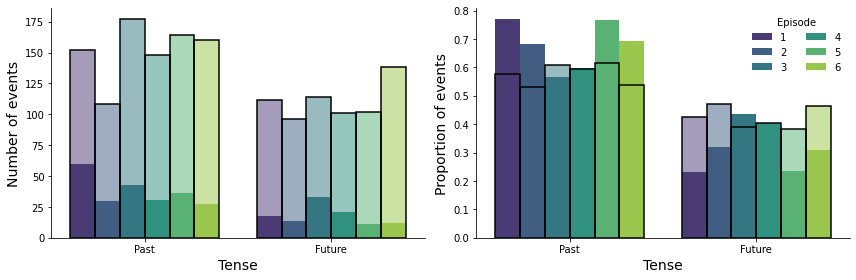

In [126]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)

# show counts
sns.barplot(data=manual, x='tense', y='count', hue='Episode', palette='viridis', ax=axes[0])
sns.barplot(data=auto, x='tense', y='count', hue='Episode', palette='viridis', alpha=0.5, ax=axes[0])
sns.barplot(data=auto, x='tense', y='count', hue='Episode', fill=False, edgecolor='k', linewidth=1.5, ax=axes[0])
axes[0].get_legend().remove()

axes[0].set_xlabel('Tense', fontsize=14)
axes[0].set_ylabel('Number of events', fontsize=14)
sns.despine(top=True, right=True)

# show proportions
sns.barplot(data=manual, x='tense', y='proportion', hue='Episode', palette='viridis', ax=axes[1])
sns.barplot(data=auto, x='tense', y='proportion', hue='Episode', palette='viridis', alpha=0.5, ax=axes[1])
sns.barplot(data=auto, x='tense', y='proportion', hue='Episode', fill=False, edgecolor='k', linewidth=1.5, ax=axes[1])
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(loc='upper right', title='Episode', handles=handles[:6], labels=labels[:6], frameon=False, ncol=2)

axes[1].set_xlabel('Tense', fontsize=14)
axes[1].set_ylabel('Proportion of events', fontsize=14)
sns.despine(top=True, right=True)

plt.tight_layout()
fig.savefig('the_chair_events.pdf', bbox_inches='tight')

# Download datasets

## [Internet Movie Script Database (IMSDb)](https://imsdb.com/)

In [165]:
imsdb_dir = str(Path.cwd().parent.joinpath('data').joinpath('imsdb'))
if not os.path.exists(imsdb_dir):
  os.makedirs(imsdb_dir)

In [166]:
def get_imsdb():
    ALL_URL = "https://imsdb.com/all-scripts.html"
    BASE_URL = "https://imsdb.com"
    SOURCE = "imsdb"

    def get_script_from_url(script_url):
        text = ""

        try:
            if script_url.endswith('.pdf'):
                text = get_pdf_text(script_url, os.path.join(SOURCE, file_name))
                return text

            if script_url.endswith('.html'):
                script_soup = get_soup(
                    script_url)
                if script_soup == None:
                    return text
                if len(script_soup.find_all('td', class_="scrtext")) < 1:
                    return ""
                script_text = script_soup.find_all(
                    'td', class_="scrtext")[0].pre

                if script_text:
                    script_text = script_soup.find_all(
                        'td', class_="scrtext")[0].pre.pre
                    if script_text:
                        text = script_text.get_text()

                    else:
                        script_text = script_soup.find_all(
                            'td', class_="scrtext")[0].pre
                        text = script_text.get_text()
        except Exception as err:
            # print(script_url)
            # print(err)
            text = ""

        return text

    def get_script_url(movie):
        script_page_url = movie.contents[0].get('href')
        name = movie.contents[0].text
        movie_name = script_page_url.split("/")[-1].strip('Script.html')

        script_page_soup = get_soup(BASE_URL + urllib.parse.quote(script_page_url))
        if script_page_soup == None:
            return "", name
        paras = script_page_soup.find_all('p', align="center")
        if len(paras) < 1:
            return "", ""
        script_url = paras[0].contents[0].get('href')

        return script_url, name

    soup = get_soup(ALL_URL)
    movielist = soup.find_all('p')

    for movie in tqdm(movielist, desc=SOURCE):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            script_url, name = get_script_url(movie)
    
        if script_url == "":
            continue
        
        script_url = BASE_URL + urllib.parse.quote(script_url)
        file_name = format_filename(name)

        if os.path.exists(os.path.join(imsdb_dir, file_name + '.txt')):
            continue
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            text = get_script_from_url(script_url)

        if text == "" or name == "":
            continue
        
        with open(os.path.join(imsdb_dir, file_name + '.txt'), 'w', errors="ignore") as out:
            out.write(text)

In [167]:
if os.path.exists(imsdb_dir):
    fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]
else:
    fnames = []

if len(fnames) < 1000:
    get_imsdb()
    fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]

print(f'Found {len(fnames)} IMSDB scripts.')

Found 1127 IMSDB scripts.


Display a randomly chosen excerpt from a randomly chosen transcript

In [168]:
sample = np.random.choice(fnames)

with open(os.path.join(imsdb_dir, sample), 'r') as f:
    lines = f.readlines()
    lines = [x.strip() for x in lines if len(x.strip()) > 0]

    # choose a 10 line snippet at random
    start = np.random.randint(0, len(lines) - 10)
    snippet = lines[start:start+10]

Markdown(f'**Excerpt from {sample}:**\n\n' + '\n\n'.join(snippet))

**Excerpt from Martian-The.txt:**

I vote yes.

VOGEL

If we do this, it would be over nine

hundred days of space. That is enough

space for one life.

(THEN)

Yes.

Beck thinks about it long and hard. Then:

BECK

Let's go get him.

In [211]:
Path(imsdb_dir)

PosixPath('/Users/jmanning/prediction-retrodiction-paper/data/imsdb')

In [213]:
imsdb_results_fname = Path(imsdb_dir).joinpath(f'imsdb_gpt_responses_c{chunk_size}.pkl')

if imsdb_results_fname.exists():
    with open(imsdb_results_fname, 'rb') as f:
        auto, errors = pickle.load(f)
else:
    auto, errors = generate_gpt_responses_by_chunk(imsdb_dir, prompt_file=prompt_file, api_key_file=api_key_file, chunk_size=chunk_size, max_files=3, model=model)
    #with open(imsdb_results_fname, 'wb') as f:
    #    pickle.dump((auto, errors), f)

 13%|█▎        | 112/844 [19:54<2:28:33, 12.18s/it]

Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)